In [1]:
import pandas, numpy, seaborn, scipy

In [2]:
import sklearn, sklearn.preprocessing
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.8, 9 * 0.8)})

In [4]:
input_data_file = '/Users/adrian/gd15/research/vigur/data/targeted.2024.eva/EC_72_EVA_All_ION_MODES.xlsx'

In [5]:
positivedf = pandas.read_excel(input_data_file, sheet_name='ACID_POS', index_col='SAMPLE')

# batch & replicate 2

In [6]:
wdf = positivedf[positivedf['LCMS_BATCH'] == 2]
wdf.head()

,Sample,LCMS_BATCH,TREATMENT,TIME,Cell Count,Technical replicate,Phenylalanine IS,Glucose IS,Carnitine IS,Carnitine IS.1,...,Adenine,Mannitol.1,AMP,Inosine,Glutamine,Glutamate,Taurine,ADP,N8-Acetyl Spermidine,Indole acetate
SAMPLE,,,,,,,,,,,,,,,,,,,,,
Pool,HUVEC_Pool,2,NaN,NaN,NaN,NaN,327.122,1760.276,10.733,870.958,...,219.901,65.449,648.564,0.0,551.711,453.257,2.412,354.654,42.504,9.748
Pool,HUVEC_Pool,2,NaN,NaN,NaN,NaN,306.424,1161.065,45.106,38.199,...,229.156,65.129,707.824,0.0,443.014,588.893,3.468,288.100,12.595,14.235
Pool,HUVEC_Pool,2,NaN,NaN,NaN,NaN,321.370,1260.574,46.972,42.563,...,169.375,42.674,627.912,0.0,436.787,555.055,3.471,217.204,14.796,15.090
Pool,HUVEC_Pool,2,NaN,NaN,NaN,NaN,7.948,2438.504,28.653,24.518,...,196.206,32.633,833.170,0.0,601.563,442.753,4.269,414.713,9.985,7.258
Pool,HUVEC_Pool,2,NaN,NaN,NaN,NaN,8.773,1296.640,44.843,40.368,...,157.918,64.778,678.008,0.0,1009.755,830.525,4.430,431.968,16.720,13.801


In [7]:
intensities = wdf.iloc[:, 6:]
intensities.head()

,Phenylalanine IS,Glucose IS,Carnitine IS,Carnitine IS.1,Glutamic Acid IS,AMP IS,Lysine IS,19:0 LPC IS,Alanine IS,ADMA,...,Adenine,Mannitol.1,AMP,Inosine,Glutamine,Glutamate,Taurine,ADP,N8-Acetyl Spermidine,Indole acetate
SAMPLE,,,,,,,,,,,,,,,,,,,,,
Pool,327.122,1760.276,10.733,870.958,54.815,3090.795,363.774,0.000,0.0,3.130,...,219.901,65.449,648.564,0.0,551.711,453.257,2.412,354.654,42.504,9.748
Pool,306.424,1161.065,45.106,38.199,0.000,3509.767,307.801,0.815,0.0,23.701,...,229.156,65.129,707.824,0.0,443.014,588.893,3.468,288.100,12.595,14.235
Pool,321.370,1260.574,46.972,42.563,0.000,3186.258,475.754,0.000,0.0,14.951,...,169.375,42.674,627.912,0.0,436.787,555.055,3.471,217.204,14.796,15.090
Pool,7.948,2438.504,28.653,24.518,0.000,4068.140,502.962,0.000,0.0,2.963,...,196.206,32.633,833.170,0.0,601.563,442.753,4.269,414.713,9.985,7.258
Pool,8.773,1296.640,44.843,40.368,0.000,2919.863,479.834,0.498,0.0,7.822,...,157.918,64.778,678.008,0.0,1009.755,830.525,4.430,431.968,16.720,13.801


['Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool']
['Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool']


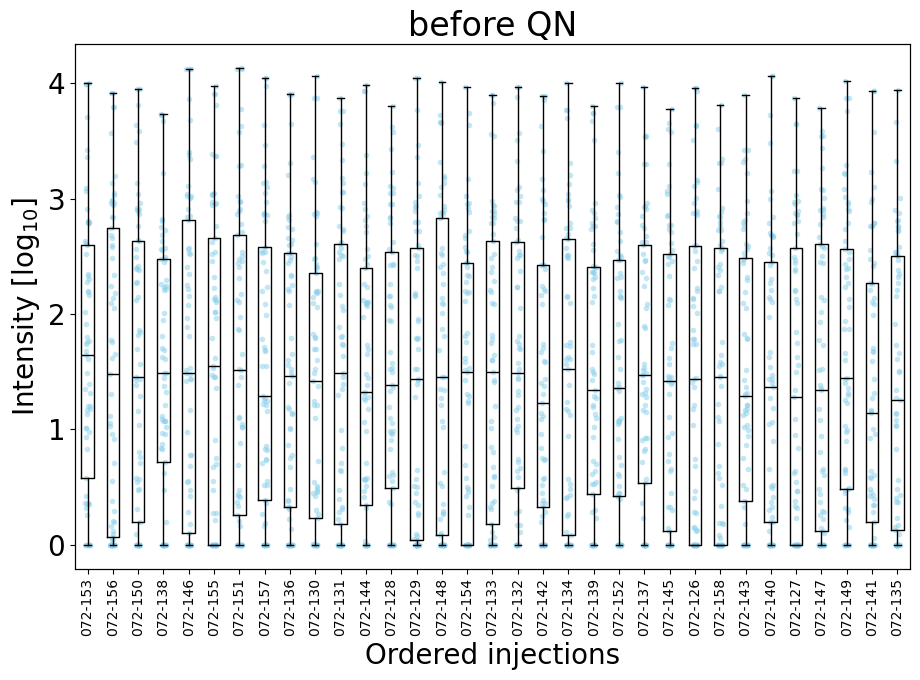

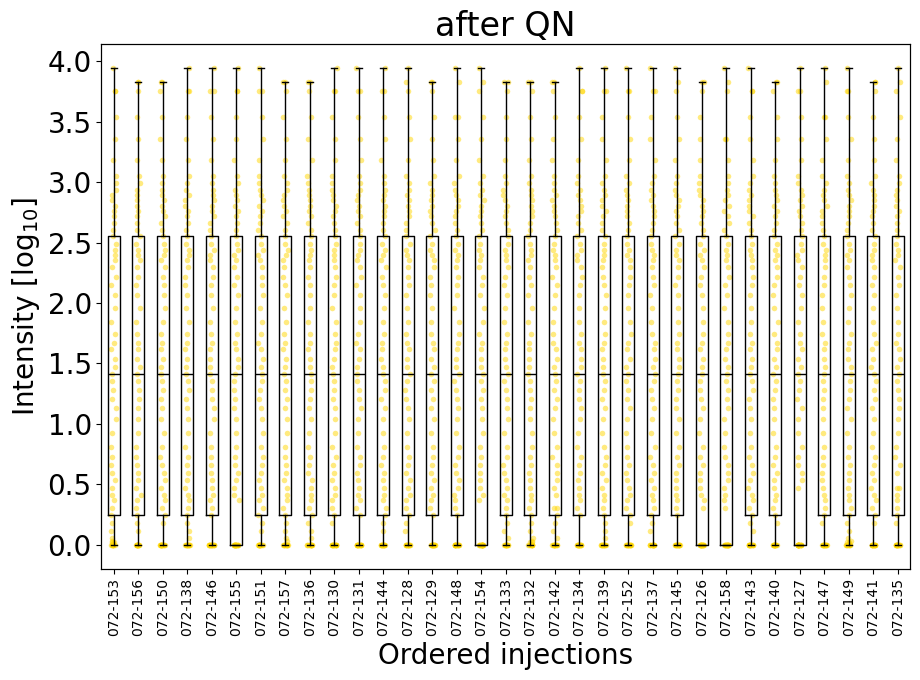

In [8]:
# transform
rocks = []
for label in wdf.index:
    if isinstance(label, str) == False:
        rocks.append(label)
    else:
        if '072' not in label:
            rocks.append(label)  
print(rocks)
# some rocks that failed
print(rocks)
#
intensities.drop(rocks, axis=0, inplace=True)

intensities = intensities.transpose()
log10_intensities = numpy.log10(intensities + 1)

#plot
ax1 = log10_intensities.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(log10_intensities, color='skyblue', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('before QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10_intensities.values, axis=0), 
                             index=log10_intensities.index, 
                             columns=log10_intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10_intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

# plot after
ax1 = df_qn.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_qn, color='gold', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('after QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

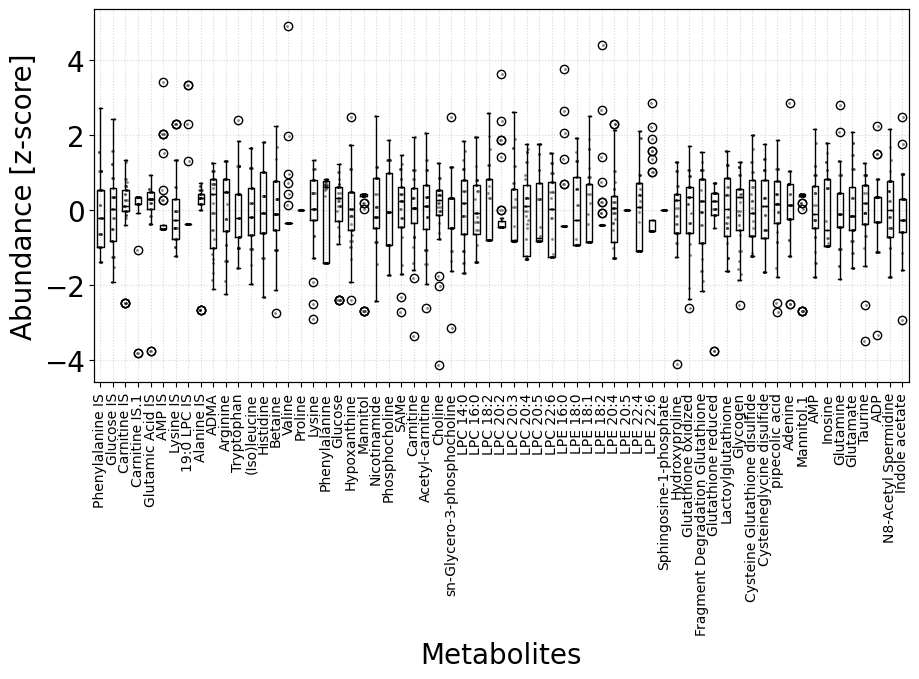

In [9]:
# transpose & scale
t_df_qn = df_qn.transpose()
std_scaler = sklearn.preprocessing.StandardScaler()
df_std = pandas.DataFrame(std_scaler.fit_transform(t_df_qn), columns=t_df_qn.columns, index=t_df_qn.index)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [10]:
print(log10_intensities.loc['Glucose IS'].values)
print(df_qn.loc['Glucose IS'].values)

[2.61415343 2.74714447 2.76376706 2.6342273  2.85285374 2.9527692
 2.77607835 2.80740107 2.73452141 2.86883539 2.92296407 2.71158032
 2.78579663 2.89454368 3.03266307 2.72005092 2.83861111 2.74173683
 2.9769801  3.13059395 2.40219602 2.71064277 2.93770341 2.77232391
 2.87647765 2.59835271 2.5248931  2.84382244 2.80920136 3.0041545
 3.08447904 2.99605174 2.58463648]
[2.60003369 2.55725757 2.66489006 2.85349404 2.66489006 2.71853236
 2.66489006 2.60003369 2.85349404 2.93548163 2.85349404 2.80344568
 2.71853236 2.85349404 2.85349404 2.89282473 2.80344568 2.66489006
 2.93548163 3.05074658 2.4914435  2.80344568 2.99449097 2.85349404
 2.76280055 2.60003369 2.60003369 3.05074658 2.71853236 2.93548163
 2.99449097 3.18491042 2.76280055]


In [11]:
print(log10_intensities.loc['Glutamate'].values)
print(df_qn.loc['Glutamate'].values)

[2.59819499 2.48541618 2.56059401 2.56516516 2.52322995 2.5188665
 2.53863028 2.54066602 2.53216941 2.47576849 2.47881171 2.50142353
 2.43625172 2.50827513 2.50825087 2.5453232  2.51917278 2.50967421
 2.2003333  2.51356916 2.76197592 2.46545126 2.60026373 2.51579439
 2.45619745 2.62831842 2.44523046 2.52984597 2.46772942 2.59060669
 2.47503744 2.08239038 2.53530805]
[2.55725757 2.29932105 2.4914435  2.76280055 2.35546563 2.39917692
 2.4914435  2.43821817 2.60003369 2.76280055 2.29932105 2.71853236
 2.4914435  2.4914435  2.39917692 2.71853236 2.4914435  2.39917692
 2.35546563 2.43821817 2.80344568 2.4914435  2.55725757 2.55725757
 2.43821817 2.66489006 2.43821817 2.66489006 2.43821817 2.4914435
 2.43821817 2.29932105 2.66489006]


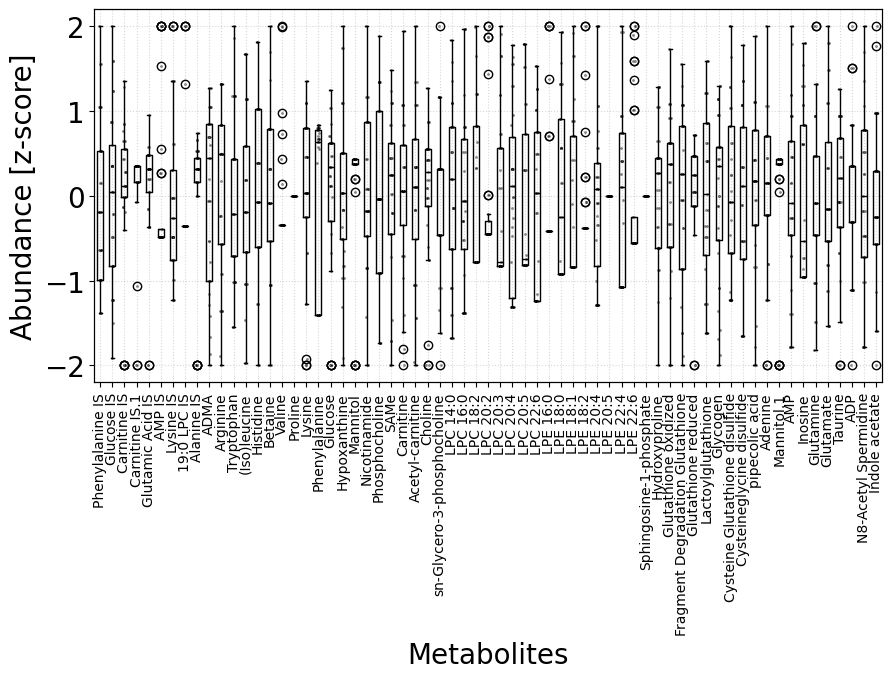

In [12]:
# clip
df_std.clip(-2, 2, inplace=True)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

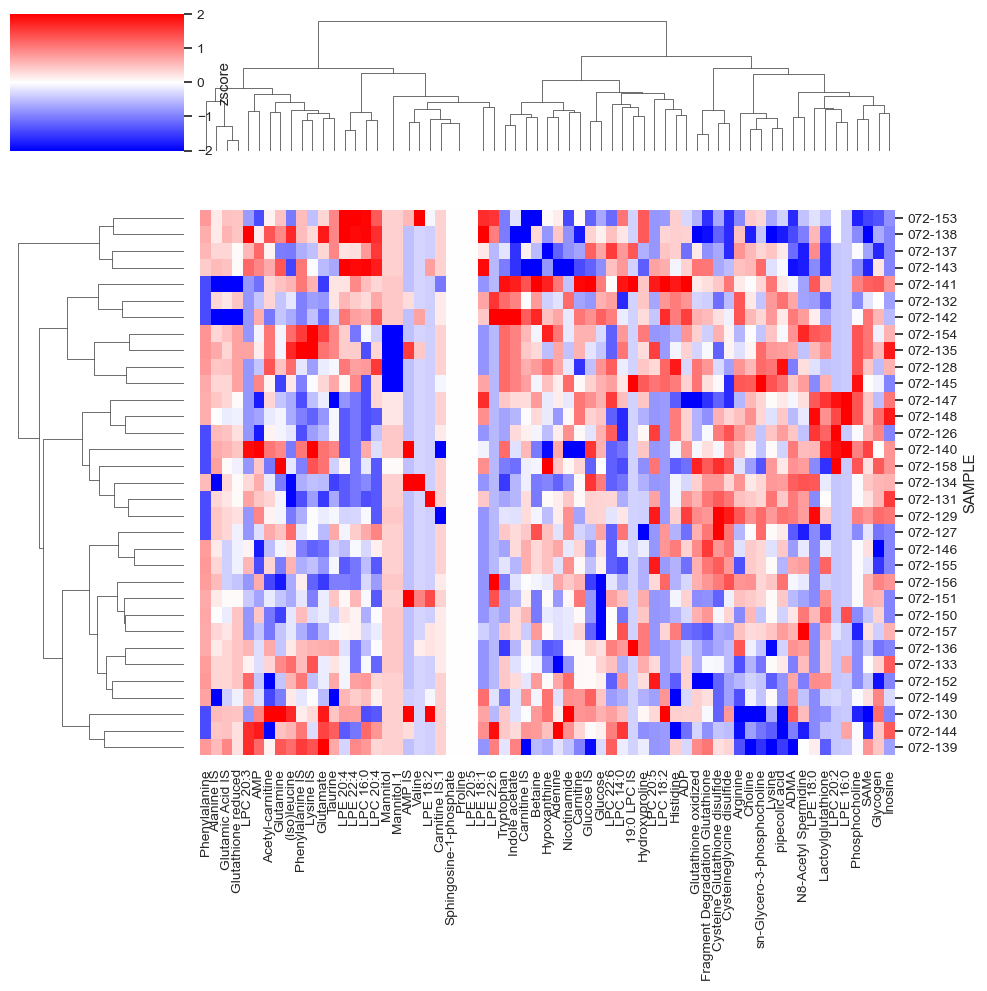

In [13]:
# visualize pattern
linkage_method = 'ward'
distance_metric = 'euclidean'

seaborn.set(font_scale=0.9)
seaborn.clustermap(df_std, 
                   cmap='bwr', col_cluster=True, vmin=-2, vmax=2, 
                   method=linkage_method, metric=distance_metric, 
                   yticklabels=1, xticklabels=1,
                   cbar_kws={'label':'zscore'})
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

seaborn.reset_orig()

In [14]:
print(df_std['Alanine IS'].mean())
print(df_std['Alanine IS'].std())

0.07912797799862298
0.803194098969084


In [15]:
# test
timepoints = [4, 24]
timepoints = [4, 24]
control_label = '0µM'
sample_label = '5 µM epi:nor'
metabolites = df_std.columns

for timepoint in timepoints:
    print('Timepoint {}'.format(timepoint))
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == control_label)
    controls = wdf[rules].index.to_list()
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == sample_label)
    samples = wdf[rules].index.to_list()

    uncorrected = []
    for metabolite in metabolites:
        #print('\t', metabolite)
        existing = [control for control in controls if control in df_std.index]
        x = df_std.loc[existing, metabolite]
        existing = [sample for sample in samples if sample in df_std.index]
        y = df_std.loc[samples, metabolite]

        (statistic, pvalue) = scipy.stats.ttest_ind(x, y)
        if numpy.isnan(pvalue) == True:
            pvalue = 1
        uncorrected.append(pvalue)
        if pvalue < 0.05:
            #print('\t\t', x.values, y.values, pvalue)
            print(metabolite)
    results = statsmodels.stats.multitest.multipletests(uncorrected, method='fdr_bh')
    print('We found significant metabolites:', sum(results[0]))
    print(results)

    # plot significant
    for i in range(len(metabolites)):
        if results[0][i] == True:
            print(metabolites[i], results[1][i])
            metabolite = metabolites[i]
            a = df_std.loc[controls, metabolite]
            b = df_std.loc[samples, metabolite]
            matplotlib.pyplot.boxplot([a, b])
            matplotlib.pyplot.title('{}; P = {:.4f}'.format(metabolite, results[1][i]))
            matplotlib.pyplot.xticks([1, 2], ['0 µM', '5 µM epi:nor'])
            matplotlib.pyplot.ylabel('Abundance [z-score]')
            matplotlib.pyplot.grid(ls=':', alpha=0.5)
            matplotlib.pyplot.tight_layout()
            matplotlib.pyplot.show()

Timepoint 4
Phenylalanine IS
Nicotinamide
Carnitine
LPC 16:0
LPC 20:3
LPC 20:4
LPC 20:5
Taurine
We found significant metabolites: 0
(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), array([0.36382081, 1.        , 0.57623373, 1.        , 0.42127616,
       1.        , 0.4509458 , 1.        , 1.        , 0.4509458 ,
       1.        , 1.        , 0.91418664, 1.        , 1.        ,
       1.        , 1.        , 0.4509458 , 0.4509458 , 0.84241638,
       0.4509458 , 1.        , 0.36382081, 1.        , 1.        ,
       0.36382081, 

/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531